<div align="center">

# Exeperiments demonstrating a posteriori error analysis for Schwarz overlapping domain decomposition methods


## Author: Jehanzeb H Chaudhary
    
#### Department of Mathematics and Statistics
#### University of New Mexico
    
    
### Research supported by NSF grant # 1720402





This notebook numerically illustrates the a posteriori estimates derived in the work:


<a id="1"></a> 
Chaudhry, Estep, Tavener. A posteriori error analysis for Schwarz overlapping domain decomposition methods. BIT Numerical Mathematics (2021)

The error estimates are for an elliptic PDE of the form

$$ a(u,v) = l(v) $$

The PDE is solved using either additive or multiplicative Schwarz domain decomposition algorthms. Let the numerical solution be $U^{K}$, where $K$ denotes the number of domain decomposition iterations. Then the error in a quantity-of-interest (QoI) may be decomposed as

$$ \text{Total Error} =  Q(u - U^{K}) =  \text{Iteration Error} + \text{Discretization Error}$$

This notebook illustrates the error estimates for the total error and discretization error (and if these are accurate, then so must be the estimate for iteration error). The notebook computes the error estimates and then computes their effectivity ratios. An effectivity ratio, which is a ratio of true error and computed error, close to one indicates the error estimates are accurate. The details are given in the reference above.

In [26]:
from dolfin import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


from dd_engine import get_engine
from helper_classes_and_functions import  get_pde, QoI
from physical_pde_problems import Poisson, ConvectionDiffusion
from error_handler import ErrorHandler

import copy

In [27]:
#Some parameters

num_domains = 4 #The configuration of the domains is given later
Schwarz_It = 6 #Number of Schwarz Domain Decomposition Iterations
method = 'multiplicative-schwarz' #Choose the domain decomposition method
num_ele_x = 10 #  mesh elements in x-direction
num_ele_y = 10 #  mesh elements in y-direction 

#The QoI is represented by the characteristic function of a rectangle
qoi_coeff = QoI(degree=0)
qoi_coeff.init_parms(x_beg=0.6, y_beg =0.6, x_len=0.2, y_len=0.2)

#Create the domain decomposition engine. 
#Parameters:
# dd_method: Options are 'multiplicative-schwarz', 'additive-schwarz'
# overlap_parameter: Any "reasonable" real number. Indicates overlap between subdomains
# num_ele_x: Number of mesh elements in x direction
# num_ele_y: Number of mesh elements in y direction
# config_domains: A list of two numbers as [m,n]. Domains are in a m x n configuration
# num_domains: Product of elements of config_domains
# pde:  Options are Poisson(), ConvectionDiffusion()
# qoi_coeff:  #The Quantity-of-Interest function



dd_engine = get_engine(dd_method = method,\
                       overlap_parameter=0.2,\
                       num_ele_x=num_ele_x,num_ele_y=num_ele_y,\
                       config_domains = [2,2], \
                       num_domains=num_domains, \
                       pde=Poisson(),\
                       qoi_coeff = qoi_coeff)

#Initialize the engine (function spaces for the whole mesh, as well as for subdomain meshes)
dd_engine.init_mesh_spaces()



#The error_logger object will compute the a posteriori error estimate.
a_posteriori_error_handler = ErrorHandler(schwarz_iterations = Schwarz_It,num_domains=num_domains,dd_engine=dd_engine)




In [28]:
#Now we compute the primal solution. That is, solution to the PDE using Schwarz domain decomposition.

a_posteriori_error_handler.save_global_soln() #Save the global solution

for sit in range(Schwarz_It):
	dd_engine.do_primal_sweep()          #This does a single sweep. That is, goes through all subdomains to compute the solution

	a_posteriori_error_handler.save_dd_pr_solns()  #Save subdomain solutions
	a_posteriori_error_handler.save_global_soln()  #Save the global solution

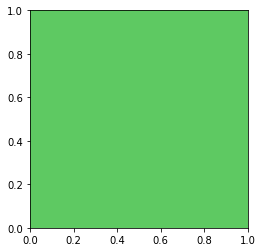

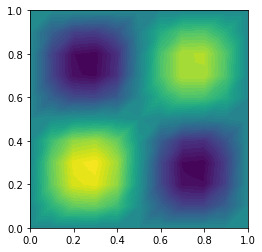

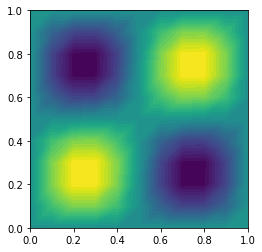

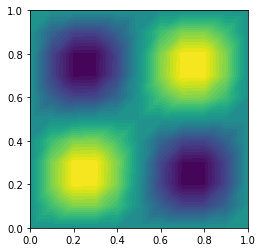

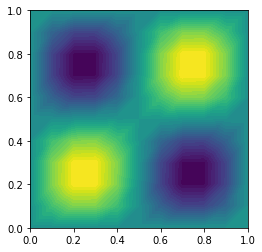

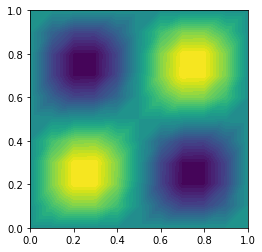

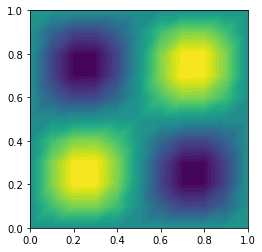

In [29]:
# We can plot these solutions
for k in range(Schwarz_It+1):
    plt.figure()
    plot(a_posteriori_error_handler.pr_soln_combined[k])

In [30]:
# Compute the true error (to later compute the effectivity ratio)
true_tot_err = dd_engine.compute_qoi_error(Schwarz_It)
a_posteriori_error_handler.true_tot_err = true_tot_err

In [31]:
#Solving the adjoint problems now. There are two types of adjoints to solve: subdomain discretization adjoints and a global adjoint.

#Discretization adjoints

dd_engine.init_adjoints()

for sit in range(Schwarz_It-1,-1,-1):
	for i in range(num_domains-1,-1,-1):
		dd_engine.solve_adj_on_subdomain(i)
	
	dd_engine.do_adj_bookeeping_after_one_sweep()
	a_posteriori_error_handler.save_dd_adj_solns()
    

In [32]:
#Compute the discretization error
if method  == 'multiplicative-schwarz':
	[error,extra_stuff] = a_posteriori_error_handler.compute_gs_disc_error()
	[sRi, sRi_arr] = extra_stuff
else:
	a_posteriori_error_handler.compute_jacobi_disc_error()

print ('Discretization error computed is %g' %(a_posteriori_error_handler.disc_err))

Discretization error computed is 0.00235563


In [33]:
#solve global adjoint and total error
dd_engine.solve_global_adjoint()	
a_posteriori_error_handler.global_adj = dd_engine.global_adjoint
a_posteriori_error_handler.compute_total_error()

#Compute iteration error
a_posteriori_error_handler.compute_iteration_error()

print ('Iteration error computed is %g' %(a_posteriori_error_handler.it_err))
print ('Total error computed is %g' %(a_posteriori_error_handler.tot_err))

Iteration error computed is 6.98325e-06
Total error computed is 0.00236262


In [34]:
# Compute the true discretization error to compute effectivity ratios	

qois_comp = a_posteriori_error_handler.compute_per_it_qois() #QoIs for the primal solution

# We approximate the "true" or reference solution on a finer mesh
num_ele_x_2 = num_ele_x*2
num_ele_y_2 = num_ele_y*2 

dd_engine.primal_deg = dd_engine.ref_soln_deg 
dd_engine.init_mesh_spaces()

# Do the primal iteration on the refined mesh
apos_error_hand_2 = ErrorHandler(schwarz_iterations=Schwarz_It,num_domains=num_domains,dd_engine=dd_engine)
apos_error_hand_2 .save_global_soln()	
for sit in range(Schwarz_It):
    dd_engine.do_primal_sweep()
    apos_error_hand_2.save_dd_pr_solns()
    apos_error_hand_2.save_global_soln()

# Approximate the true QoIs
qois_true = apos_error_hand_2.compute_per_it_qois()


per_it_disc_errs = np.array(qois_true) - np.array(qois_comp)
a_posteriori_error_handler.true_disc_err = per_it_disc_errs[-1]
print ('True discretization error is %g' %per_it_disc_errs[-1] )

True discretization error is 0.00238069


In [38]:
#Compute Effectivity ratios
print('Effectivity ratio for the total error is %g' %(a_posteriori_error_handler.tot_err/a_posteriori_error_handler.true_tot_err))

print('Effectivity ratio for the discretization error is %g' %(a_posteriori_error_handler.disc_err/a_posteriori_error_handler.true_disc_err))

Effectivity ratio for the total error is 0.983455
Effectivity ratio for the discretization error is 0.989474
